# **Yahoo EDA**

Aplicaremos el mismo procedimiento para las demás variables extraídas de yahoo finance : S&P500, precio crudo del petróleo, índice VIX y índice dólar. 


In [1]:
# Importar librerias
import pandas as pd
import numpy as np
from typing import Tuple, Dict, Any
import matplotlib.pyplot as plt
import sys, os
ROOT = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(ROOT)
from utils.date import calendario_df, datetime_index
from scipy import stats
from scipy.stats import jarque_bera
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox


In [2]:
df_exog = pd.read_csv("../raw/stocks_exog_2025-01-01_to_2025-08-31.csv")

Generamos el calendario con las fechas faltantes para la serie, dando un resumen de las filas que se insertaron.

Teniendo df_ipc_f el calnedario completo, tanto dias operables como no opearables

In [3]:
df_exog_f, info_exg = calendario_df(df_exog, date_col="Date")
info_exg

{'filas_originales': 1428,
 'filas_esperadas': 2072,
 'filas_insertadas': 644,
 'primer_falta': datetime.date(2020, 1, 1),
 'ultima_falta': datetime.date(2025, 8, 31)}

In [4]:
df_exog_f =  datetime_index(df_exog_f, date_col="Date", dayfirst=False)
df_exog =  datetime_index(df_exog, date_col="Date", dayfirst=False)

### **Datos Faltantes**

In [5]:
df_exog_f

,sp500,wti_oil,vix,dollar_index
Date,,,,
2019-12-30,3221.290039,61.680000,14.82,96.739998
2019-12-31,3230.780029,61.060001,13.78,96.389999
2020-01-01,NaN,NaN,NaN,NaN
2020-01-02,3257.850098,61.180000,12.47,96.849998
2020-01-03,3234.850098,63.049999,14.02,96.839996
...,...,...,...,...
2025-08-27,6481.399902,64.150002,14.85,98.230003
2025-08-28,6501.859863,64.599998,14.43,97.809998
2025-08-29,6460.259766,64.010002,15.36,97.769997


In [6]:
def missing_weekday_weekend(df: pd.DataFrame) -> pd.DataFrame:
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("El índice debe ser DatetimeIndex.")
    isna = df.isna()
    is_weekend = pd.Series(df.index.weekday >= 5, index=df.index)

    weekend_missing = (isna & is_weekend.values[:, None]).sum(axis=0)
    weekday_missing = (isna & (~is_weekend).values[:, None]).sum(axis=0)

    out = pd.DataFrame({
        "weekday_missing": weekday_missing.astype(int),
        "weekend_missing": weekend_missing.astype(int),
    })
    out["total_missing"] = out["weekday_missing"] + out["weekend_missing"]
    return out.sort_values("total_missing", ascending=False)

In [7]:
def plot_weekday_weekend_missing(df: pd.DataFrame):
    tbl = missing_weekday_weekend(df)
    x = np.arange(len(tbl.index))
    w = 0.4

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.bar(x - w/2, tbl["weekday_missing"].values, width=w, label="Entre semana (L–V)")
    ax.bar(x + w/2, tbl["weekend_missing"].values, width=w, label="Fin de semana (S–D)")

    ax.set_xticks(x)
    ax.set_xticklabels(tbl.index, rotation=45, ha="right")
    ax.set_ylabel("Conteo de nulos")
    ax.set_title("Nulos por columna: Entre semana vs Fin de semana")
    ax.legend()
    plt.tight_layout()
    plt.show()
    return tbl

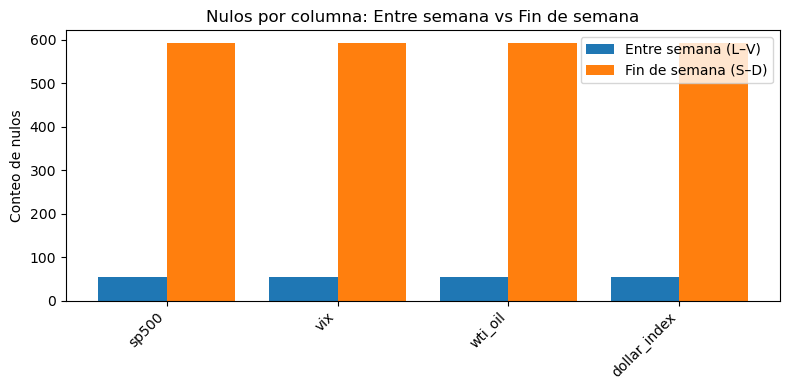

,weekday_missing,weekend_missing,total_missing
sp500,55,592,647
vix,55,592,647
wti_oil,53,592,645
dollar_index,53,592,645


In [8]:
plot_weekday_weekend_missing(df_exog_f)

Para el análisis de las series S&P 500, VIX, WTI y Dollar Index el conteo de faltantes se concentra en 
fines de semana con 592 ausencias en cada serie; en días hábiles, los faltantes son acotados: 55 en 
S&P 500 y VIX, y 53 en WTI y Dollar Index

In [9]:
def missing_by_weekday_counts(df: pd.DataFrame) -> pd.DataFrame:
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("El índice debe ser DatetimeIndex.")

    # Filtrar solo L–V
    df_biz = df[df.index.weekday < 5]
    isna = df_biz.isna()
    dow = df_biz.index.weekday  # 0..4

    counts = {}
    for col in df_biz.columns:
        c = pd.Series(dow[isna[col]].value_counts()).reindex(range(5), fill_value=0).astype(int)
        counts[col] = c

    counts_df = pd.DataFrame(counts).T
    counts_df.columns = ["Mon","Tue","Wed","Thu","Fri"]
    return counts_df

In [11]:
def plot_missing_by_weekday_counts(df: pd.DataFrame):
    counts_df = missing_by_weekday_counts(df)
    dow_labels = ["Mon","Tue","Wed","Thu","Fri"]

    for col in counts_df.index:
        fig, ax = plt.subplots(figsize=(6, 3.3))
        ax.bar(range(5), counts_df.loc[col].values)
        ax.set_xticks(range(5))
        ax.set_xticklabels(dow_labels)
        ax.set_title(f"Nulos por día (L–V): {col}")
        ax.set_xlabel("Día de la semana")
        ax.set_ylabel("Conteo de nulos")
        plt.tight_layout()
        plt.show()
    return counts_df

In [12]:
counts_df = missing_by_weekday_counts(df_exog_f)
counts_df

,Mon,Tue,Wed,Thu,Fri
sp500,31,1,4,8,11
wti_oil,31,1,4,7,10
vix,31,1,4,8,11
dollar_index,30,1,4,7,11


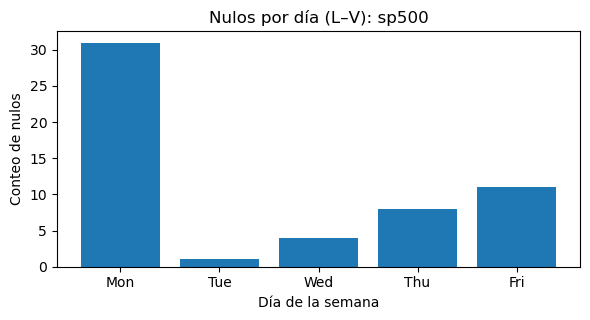

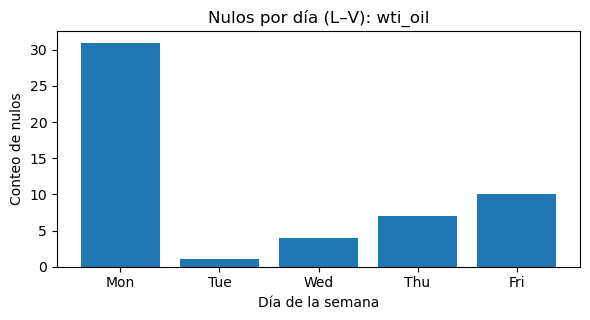

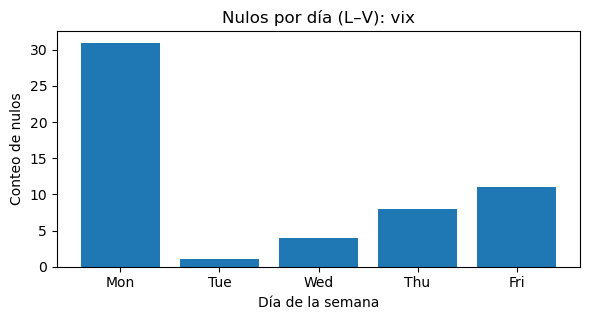

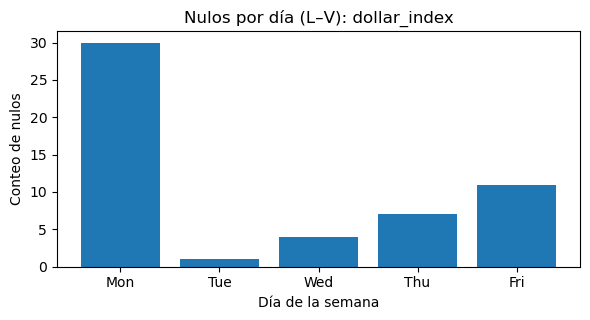

In [13]:
counts_df = plot_missing_by_weekday_counts(df_exog_f)

En días hábiles, la distribución de valores faltantes presenta el mismo patrón en las cuatro series de Yahoo, 
como se muestra. El mayor número se concentra los lunes, con 31 faltantes en S&P 500, 31 en 
WTI, 31 en VIX y 30 en Dollar Index; los martes casi no registran ausencias, con 1 en cada serie; los miércoles 
suman 4; los jueves oscilan entre 7 y 8; y los viernes entre 10 y 11.    

In [14]:
# Filas con al menos un NaN
null_days = df_exog_f[df_exog_f.isna().any(axis=1)]

# Filtrar solo días entre semana (0=lunes ... 4=viernes)
weekday_nulls = null_days[null_days.index.weekday < 5]
weekday_nulls.index


DatetimeIndex(['2020-01-01', '2020-01-20', '2020-02-17', '2020-04-10',
               '2020-05-25', '2020-07-03', '2020-09-07', '2020-11-26',
               '2020-12-25', '2021-01-01', '2021-01-18', '2021-02-15',
               '2021-04-02', '2021-05-31', '2021-07-05', '2021-09-06',
               '2021-11-25', '2021-12-24', '2022-01-17', '2022-02-21',
               '2022-04-15', '2022-05-30', '2022-06-20', '2022-07-04',
               '2022-09-05', '2022-11-24', '2022-12-26', '2023-01-02',
               '2023-01-16', '2023-02-20', '2023-04-07', '2023-05-29',
               '2023-06-19', '2023-07-04', '2023-09-04', '2023-11-23',
               '2023-12-25', '2024-01-01', '2024-01-15', '2024-02-19',
               '2024-03-29', '2024-05-27', '2024-06-19', '2024-07-04',
               '2024-09-02', '2024-11-28', '2024-12-25', '2025-01-01',
               '2025-01-09', '2025-01-20', '2025-02-17', '2025-04-18',
               '2025-05-26', '2025-06-19', '2025-07-04'],
              dtype

También se realizó un análisis que relacione los días habiles 
faltantes con los días festivos del calendario operativo, mostrando si los datos faltantes son aleatorios 
o estructurados dados por fechas festivas, como se ve en el siguiente codigo

In [15]:
import pandas as pd
import numpy as np

def gaps_nan_corridas(df_or_series, value_col=None, solo_habiles=False):
   
    # 1) Obtener la serie s
    if isinstance(df_or_series, pd.DataFrame):
        if value_col is None:
            num_cols = df_or_series.select_dtypes(include=[np.number]).columns
            if len(num_cols) == 0:
                raise ValueError("Especifica 'value_col'; no hay columnas numéricas.")
            value_col = num_cols[0]
        s = df_or_series[value_col]
    else:
        s = df_or_series

    s = s.copy()
    s.index = pd.to_datetime(s.index).tz_localize(None).normalize()
    s = s.sort_index()

    # 2) Opcional: quedarse solo con días hábiles (L-V)
    if solo_habiles:
        s = s[s.index.weekday < 5]

    if s.empty:
        return (pd.DataFrame(columns=["inicio","fin","longitud","bucket"]),
                pd.Series({1:0,2:0,3:0,4:0,">=5":0}))

    # 3) Corridas de NaN: agrupar True consecutivos
    mask = s.isna()
    if not mask.any():
        return (pd.DataFrame(columns=["inicio","fin","longitud","bucket"]),
                pd.Series({1:0,2:0,3:0,4:0,">=5":0}))

    grp = mask.ne(mask.shift()).cumsum()          
    sizes = mask.groupby(grp).size()             
    is_nan = mask.groupby(grp).first()            

    runs = pd.DataFrame({"longitud": sizes, "es_nan": is_nan})
    runs = runs[runs["es_nan"]]                   

    # Obtener inicio y fin (fechas) de cada corrida
    idx_by_grp = s.index.to_series().groupby(grp)
    inicios = idx_by_grp.first()[runs.index]
    fines   = idx_by_grp.last()[runs.index]

    detalle = pd.DataFrame({
        "inicio": inicios.values,
        "fin": fines.values,
        "longitud": runs["longitud"].values
    }).sort_values("inicio").reset_index(drop=True)

    # 4) Buckets
    detalle["bucket"] = detalle["longitud"].apply(lambda k: k if k in {1,2,3,4} else ">=5")
    resumen = (detalle["bucket"].value_counts()
               .reindex([1,2,3,4,">=5"], fill_value=0)
               .astype(int))

    return detalle, resumen


También se realizo un analisis de corridas del calendario, reportando la longitud de corridas para días habiles. Se reporta para cada variable

In [17]:
# Solo días hábiles (L-V)
detalle_biz, resumen_biz = gaps_nan_corridas(df_exog_f, value_col="sp500", solo_habiles=True)
resumen_biz

bucket
1      55
2       0
3       0
4       0
>=5     0
Name: count, dtype: int32

In [18]:
# Solo días hábiles (L-V)
detalle_biz, resumen_biz = gaps_nan_corridas(df_exog_f, value_col="vix", solo_habiles=True)
resumen_biz

bucket
1      55
2       0
3       0
4       0
>=5     0
Name: count, dtype: int32

In [19]:
# Solo días hábiles (L-V)
detalle_biz, resumen_biz = gaps_nan_corridas(df_exog_f, value_col="wti_oil", solo_habiles=True)
resumen_biz

bucket
1      53
2       0
3       0
4       0
>=5     0
Name: count, dtype: int32

In [20]:
# Solo días hábiles (L-V)
detalle_biz, resumen_biz = gaps_nan_corridas(df_exog_f, value_col="dollar_index", solo_habiles=True)
resumen_biz

bucket
1      53
2       0
3       0
4       0
>=5     0
Name: count, dtype: int32

El análisis de corridas muestra huecos exclusivamente de un día en las cuatro series: en S&P 500 y 
VIX se contabilizan 55 corridas de longitud 1 como se muestra. en WTI y Dollar 
Index se contabilizan 53, véase figura 50; no se registran corridas de 2, 3, 4 ni de 5 o más días, como 
se muestra en las tablas de corridas para días hábiles.

In [23]:
df_exog_f

,sp500,wti_oil,vix,dollar_index
Date,,,,
2019-12-30,3221.290039,61.680000,14.82,96.739998
2019-12-31,3230.780029,61.060001,13.78,96.389999
2020-01-01,NaN,NaN,NaN,NaN
2020-01-02,3257.850098,61.180000,12.47,96.849998
2020-01-03,3234.850098,63.049999,14.02,96.839996
...,...,...,...,...
2025-08-27,6481.399902,64.150002,14.85,98.230003
2025-08-28,6501.859863,64.599998,14.43,97.809998
2025-08-29,6460.259766,64.010002,15.36,97.769997


### **Analisis de distribucion de datos**

In [21]:
#Convierte a numérico, elimina inf/NaN y devuelve serie limpia.
def _clean_series(s: pd.Series) -> pd.Series: 
    
    x = (pd.to_numeric(s, errors='coerce')
           .replace([np.inf, -np.inf], np.nan)
           .dropna())
    x.name = s.name
    return x
def _kde_curve(x: pd.Series, grid=400):
    kde = stats.gaussian_kde(x)
    xs = np.linspace(x.min(), x.max(), grid)
    return xs, kde(xs)

def _fmt_p(p):
    return f"{p:.3g}" if p < 0.001 else f"{p:.3f}"

def _stats_tuple(x: pd.Series):
    sk = x.skew()
    kt = x.kurt()                 # exceso de curtosis (kurtosis - 3)
    jb_stat, jb_p = jarque_bera(x)
    return sk, kt, jb_stat, jb_p

def _plot_kde_and_qq(x: pd.Series, title_prefix: str):
    var = x.name or "variable"
    sk, kt, jb, p = _stats_tuple(x)
    xs, ys = _kde_curve(x)
    plt.figure(figsize=(7,3.2))
    plt.plot(xs, ys)
    plt.title(f"{title_prefix} – KDE ({var})\n"
              f"skew={sk:.3f}, kurt(exceso)={kt:.3f}, JB={jb:.2f}, p={_fmt_p(p)}")
    plt.xlabel(var); plt.ylabel("Densidad")
    plt.tight_layout(); plt.show()

    # Q–Q plot vs Normal
    plt.figure(figsize=(4.8,4.8))
    stats.probplot(x, dist="norm", plot=plt)
    plt.title(f"{title_prefix} – Q–Q plot ({var})\nJB={jb:.2f}, p={_fmt_p(p)}")
    plt.tight_layout(); plt.show()

    # También imprime en consola
    print(f"[{title_prefix} / {var}] skew={sk:.4f}, kurt(exceso)={kt:.4f}, "
          f"JB={jb:.4f}, p={p:.6g}, n={len(x)}")


In [22]:
#  1) NIVELES
def plot_kde_qq_levels(s: pd.Series):
    #KDE y Q–Q plot para la serie en niveles (con JB).
    x = _clean_series(s)
    _plot_kde_and_qq(x, title_prefix="Niveles")


# 2) RETORNOS
def plot_kde_qq_returns(s: pd.Series, mode: str = "simple"):
    """
    KDE y Q–Q plot para retornos (con JB).
    mode = "simple" usa pct_change(); mode = "log" usa diff(log).
    """
    s = _clean_series(s)
    if mode == "log":
        r = np.log(s).diff().dropna()
        r.name = (s.name or "variable") + " (retorno log)"
    else:
        r = s.pct_change().dropna()
        r.name = (s.name or "variable") + " (retorno simple)"
    _plot_kde_and_qq(r, title_prefix="Retornos")


# 3) LOG(NIVELES)
def plot_kde_qq_log_levels(s: pd.Series):
    """KDE y Q–Q plot para log(niveles) (con JB)."""
    s = _clean_series(s)
    x = np.log(s.replace(0, np.nan)).dropna()
    x.name = (s.name or "variable") + " (log)"
    _plot_kde_and_qq(x, title_prefix="Log(niveles)")

### **DISTRIBUCION**

In [ ]:
# La fecha ya viene como índice
df_exog = df_exog.copy()
df_exog.index = pd.to_datetime(df_exog.index, errors='coerce')
df_exog= df_exog.sort_index()
s = df_exog['sp500']

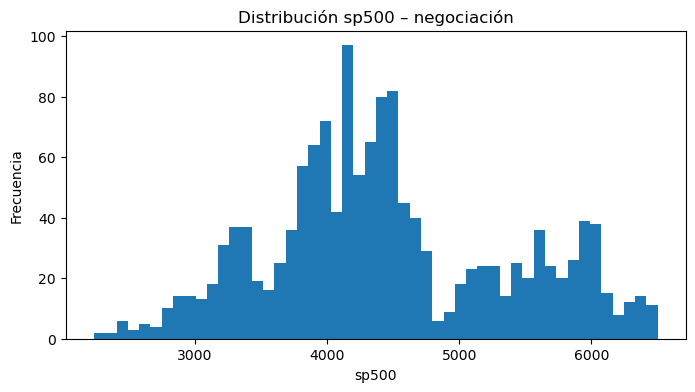

In [25]:
plt.figure(figsize=(8,4))
plt.hist(s, bins=50)
plt.title('Distribución sp500 – negociación')
plt.xlabel('sp500'); plt.ylabel('Frecuencia')
plt.show()

In [ ]:
# La fecha ya viene como índice
df_exog = df_exog.copy()
df_exog.index = pd.to_datetime(df_exog.index, errors='coerce')
df_exog = df_exog.sort_index()
s = df_exog['wti_oil']

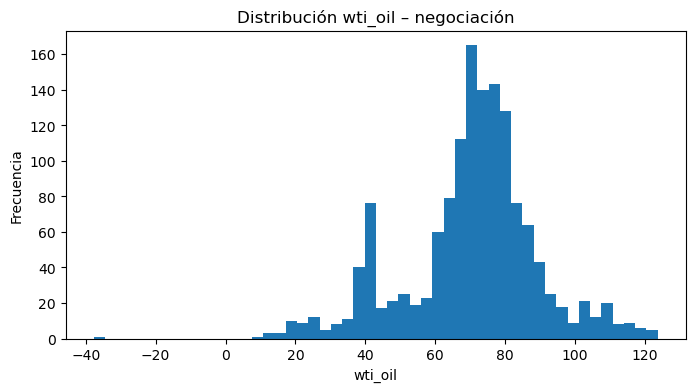

In [37]:
plt.figure(figsize=(8,4))
plt.hist(s, bins=50)
plt.title('Distribución wti_oil – negociación')
plt.xlabel('wti_oil'); plt.ylabel('Frecuencia')
plt.show()

In [ ]:
# La fecha ya viene como índice
df_exog = df_exog.copy()
df_exog.index = pd.to_datetime(df_exog.index, errors='coerce')
df_banxico = df_exog.sort_index()
s = df_exog['vix']

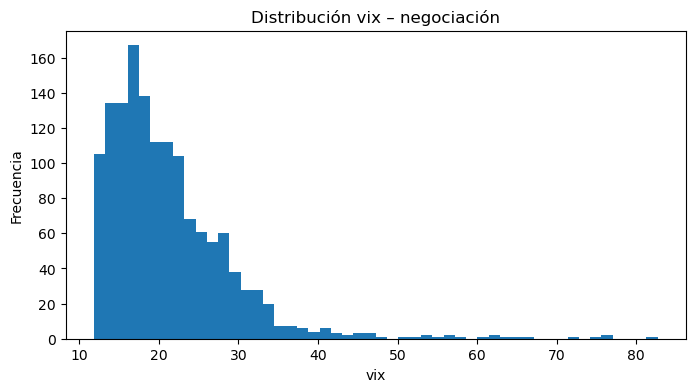

In [49]:
plt.figure(figsize=(8,4))
plt.hist(s, bins=50)
plt.title('Distribución vix – negociación')
plt.xlabel('vix'); plt.ylabel('Frecuencia')
plt.show()

In [ ]:
# La fecha ya viene como índice
df_exog = df_exog.copy()
df_exog.index = pd.to_datetime(df_exog.index, errors='coerce')
df_exog = df_exog.sort_index()
s = df_exog['dollar_index']

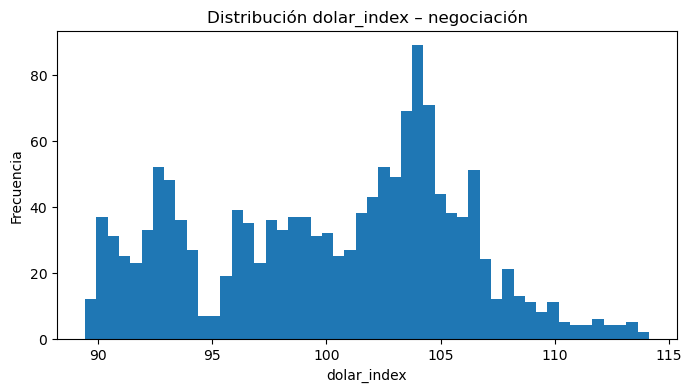

In [59]:
plt.figure(figsize=(8,4))
plt.hist(s, bins=50)
plt.title('Distribución dolar_index – negociación')
plt.xlabel('dolar_index'); plt.ylabel('Frecuencia')
plt.show()

Para el anisis de distribución, las variables presentan patrones de distribución heterogéneos, como se observa en la Figura 53. El S&P 500 muestra una distribución multimodal y dispersa, reflejando distintos regímenes de comportamiento del mercado bursátil. El VIX presenta una asimetría positiva pronunciada, con alta concentración en valores bajos y una cola extendida. Por su parte, el Dollar Index exhibe múltiples picos locales y una leve tendencia hacia la derecha. En conjunto, estas distribuciones confirman que las series son no estacionarias y no normales, por lo que se requiere su transformación logarítmica previa antes del análisis de retornos e imputación. 


### **Analisis Descriptivo**

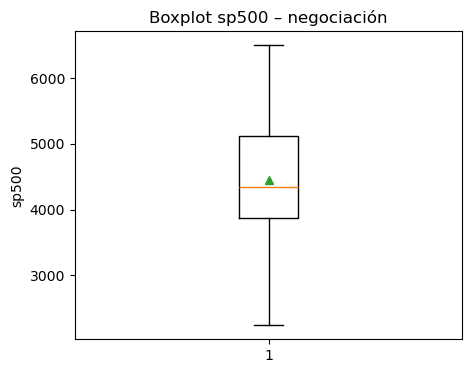

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
plt.boxplot([x.values], vert=True, showfliers=True, showmeans=True)
plt.title('Boxplot sp500 – negociación')
plt.ylabel('sp500')
plt.show()


In [28]:
desc = s.describe()
skew_raw = s.skew()
kurt_raw = s.kurt()
print(desc)
print(f"Asimetría (skew): {skew_raw:.4f}")
print(f"Curtosis (kurt): {kurt_raw:.4f}")

count    1425.000000
mean     4454.193200
std       910.131907
min      2237.399902
25%      3875.439941
50%      4343.540039
75%      5117.089844
max      6501.859863
Name: sp500, dtype: float64
Asimetría (skew): 0.3076
Curtosis (kurt): -0.5451


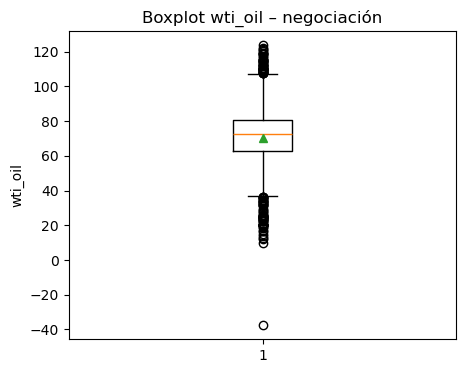

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
plt.boxplot([x.values], vert=True, showfliers=True, showmeans=True)
plt.title('Boxplot wti_oil – negociación')
plt.ylabel('wti_oil')
plt.show()


In [40]:
desc = s.describe()
skew_raw = s.skew()
kurt_raw = s.kurt()
print(desc)
print(f"Asimetría (skew): {skew_raw:.4f}")
print(f"Curtosis (kurt): {kurt_raw:.4f}")

count    1427.000000
mean       70.499257
std        19.073690
min       -37.630001
25%        63.035000
50%        72.360001
75%        80.745003
max       123.699997
Name: wti_oil, dtype: float64
Asimetría (skew): -0.4710
Curtosis (kurt): 1.2123


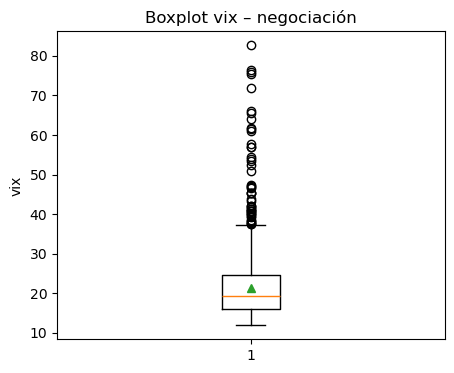

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
plt.boxplot([x.values], vert=True, showfliers=True, showmeans=True)
plt.title('Boxplot vix – negociación')
plt.ylabel('vix')
plt.show()


In [52]:
desc = s.describe()
skew_raw = s.skew()
kurt_raw = s.kurt()
print(desc)
print(f"Asimetría (skew): {skew_raw:.4f}")
print(f"Curtosis (kurt): {kurt_raw:.4f}")

count    1425.000000
mean       21.219382
std         8.053773
min        11.860000
25%        15.970000
50%        19.309999
75%        24.469999
max        82.690002
Name: vix, dtype: float64
Asimetría (skew): 2.5674
Curtosis (kurt): 11.4505


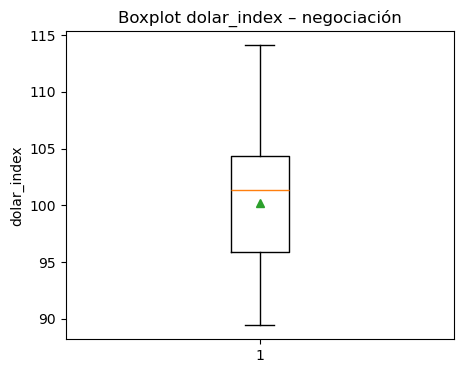

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
plt.boxplot([x.values], vert=True, showfliers=True, showmeans=True)
plt.title('Boxplot dolar_index – negociación')
plt.ylabel('dolar_index')
plt.show()


In [62]:
desc = s.describe()
skew_raw = s.skew()
kurt_raw = s.kurt()
print(desc)
print(f"Asimetría (skew): {skew_raw:.4f}")
print(f"Curtosis (kurt): {kurt_raw:.4f}")

count    1427.000000
mean      100.205543
std         5.625327
min        89.440002
25%        95.860001
50%       101.339996
75%       104.334999
max       114.110001
Name: dollar_index, dtype: float64
Asimetría (skew): -0.1533
Curtosis (kurt): -0.8908


Añadiendo al análisis descriptivo, evidencia diferencias significativas en dispersión y asimetría. El S&P 500 presenta una distribución simétrica y amplia variabilidad, reflejando distintos regímenes de precios. El WTI Oil muestra alta dispersión y valores atípicos, con una asimetría negativa. El VIX destaca por su sesgo positivo pronunciado y colas largas, indicando eventos de volatilidad extrema. En contraste, el Dollar Index presenta una distribución estable y casi simétrica, con baja curtosis y variabilidad moderada.


### **Evaluación de normalidad y colas**

#### **SP500**

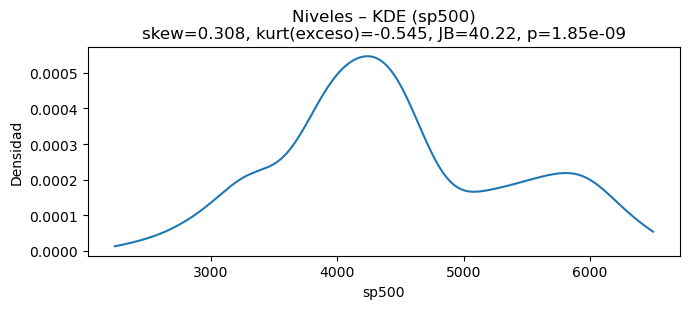

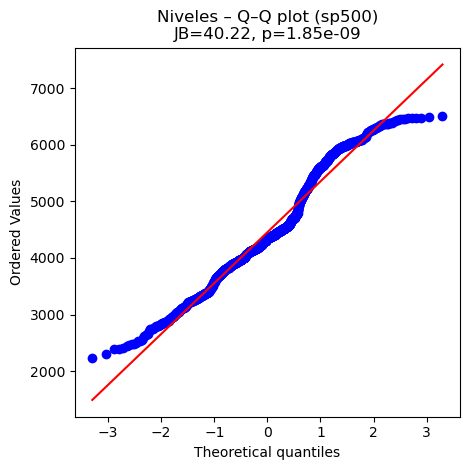

[Niveles / sp500] skew=0.3076, kurt(exceso)=-0.5451, JB=40.2170, p=1.84923e-09, n=1425


In [29]:
plot_kde_qq_levels(s)

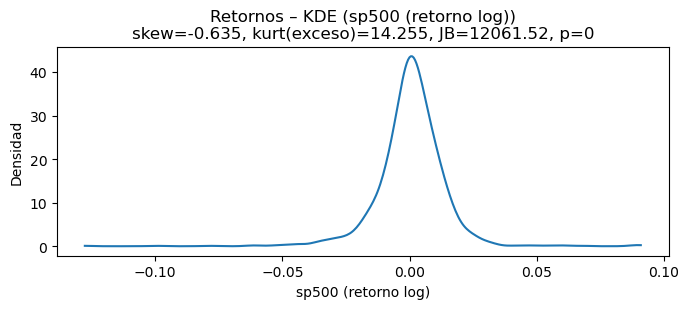

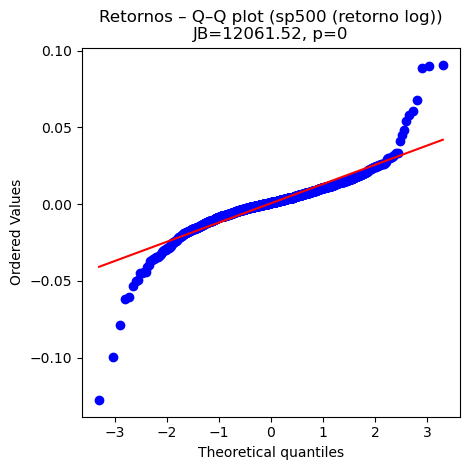

[Retornos / sp500 (retorno log)] skew=-0.6354, kurt(exceso)=14.2554, JB=12061.5181, p=0, n=1424


In [30]:
plot_kde_qq_returns(s, mode="log")  

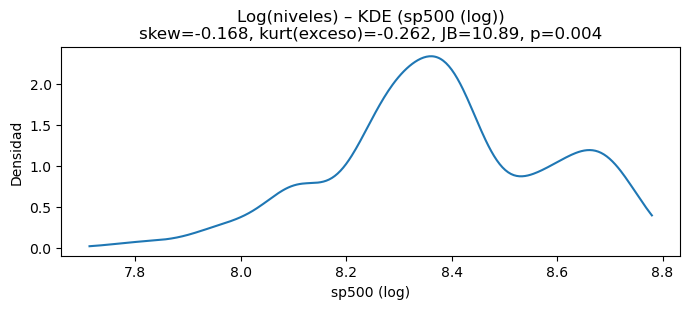

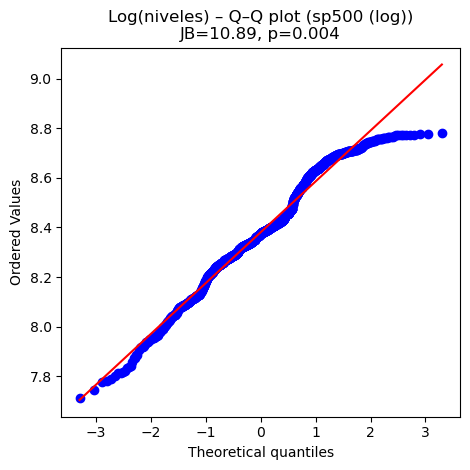

[Log(niveles) / sp500 (log)] skew=-0.1684, kurt(exceso)=-0.2619, JB=10.8941, p=0.0043089, n=1425


In [31]:
plot_kde_qq_log_levels(s)


Igualmente estimando las densidades, mediante KDE, y construyendo los diagramas Q-Q para cada variable. Para el SP500, la transformación logarítmica suaviza ligeramente la forma, aunque mantiene la bimodalidad estructural. En cambio, los retornos simples se concentran alrededor de cero, mostrando una forma leptocúrtica típica de series financieras.Los Q-Q plots confirman que los niveles y log(niveles) se desvían de la normalidad, mientras que los retornos presentan un ajuste más cercano, salvo en las colas

#### **WTI_OIL**

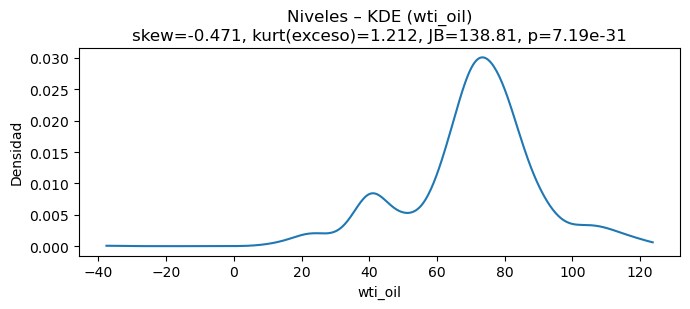

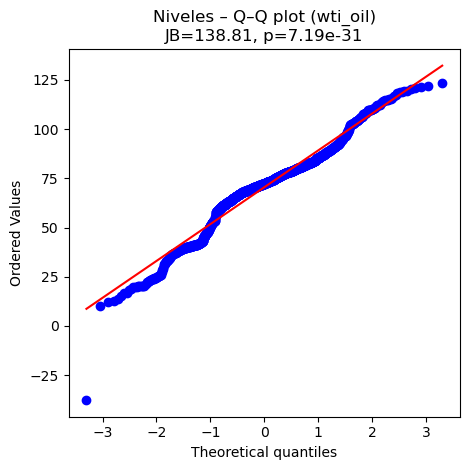

[Niveles / wti_oil] skew=-0.4710, kurt(exceso)=1.2123, JB=138.8145, p=7.19128e-31, n=1427


In [41]:
plot_kde_qq_levels(s)

c:\Users\marti\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


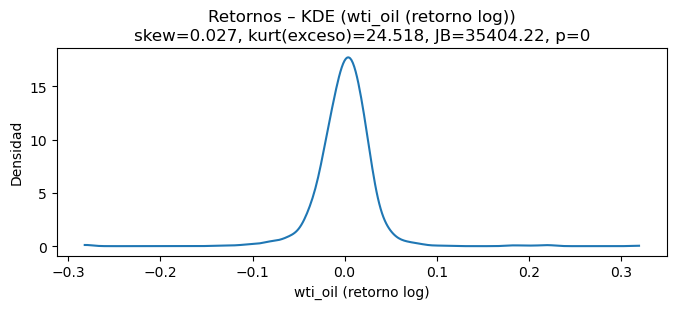

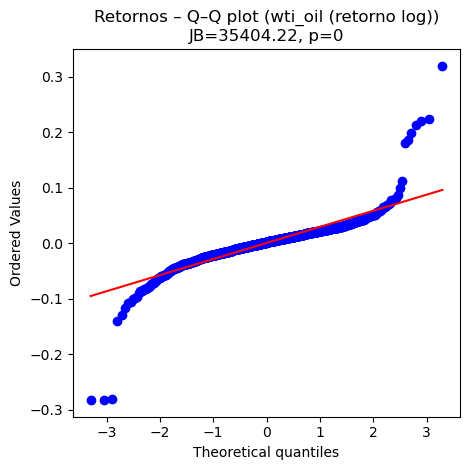

[Retornos / wti_oil (retorno log)] skew=0.0273, kurt(exceso)=24.5176, JB=35404.2218, p=0, n=1424


In [42]:
plot_kde_qq_returns(s, mode="log")  

La variable WTI Oil presenta una distribución asimétrica y multimodal, concentrada entre 60 y 90, con valores extremos negativos. La transformación logarítmica atenúa parcialmente esta asimetría, aunque la distribución sigue siendo sesgada y presenta una ligera bimodalidad. Los retornos simples exhiben una fuerte concentración en torno a cero y colas gruesas.

#### **VIX**

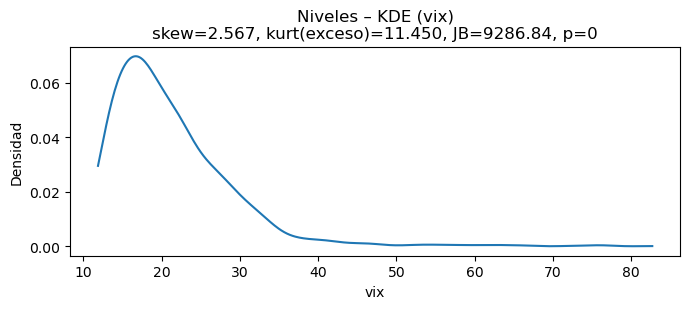

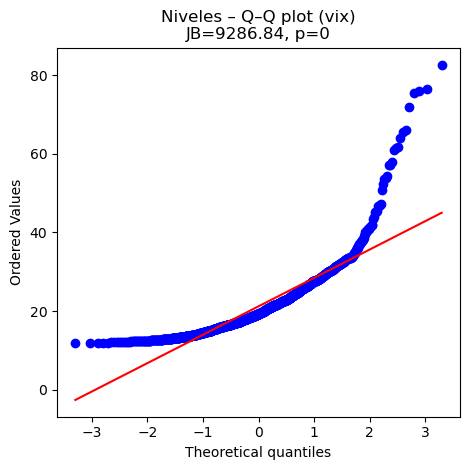

[Niveles / vix] skew=2.5674, kurt(exceso)=11.4505, JB=9286.8416, p=0, n=1425


In [53]:
plot_kde_qq_levels(s)

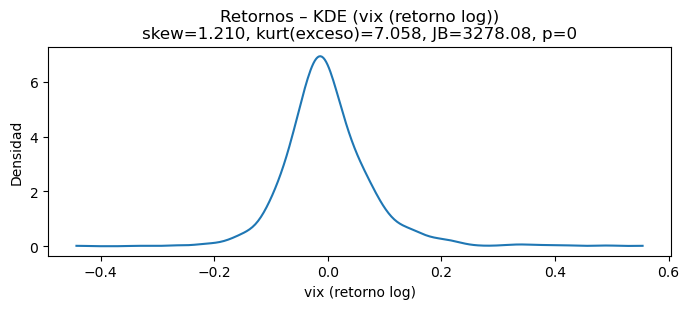

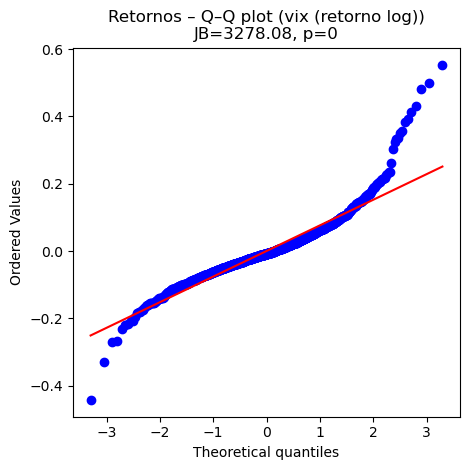

[Retornos / vix (retorno log)] skew=1.2095, kurt(exceso)=7.0581, JB=3278.0819, p=0, n=1424


In [54]:
plot_kde_qq_returns(s, mode="log")  

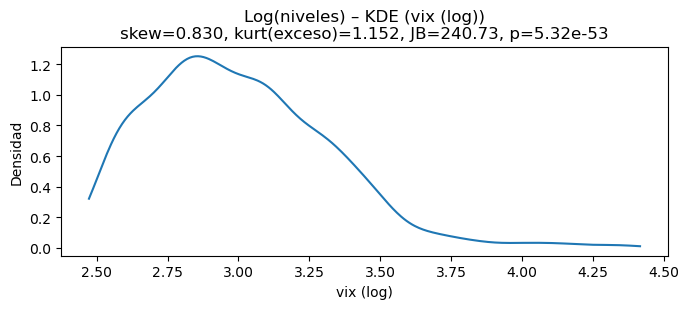

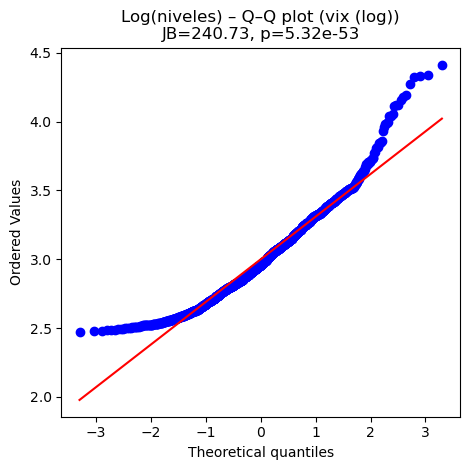

[Log(niveles) / vix (log)] skew=0.8296, kurt(exceso)=1.1516, JB=240.7328, p=5.31536e-53, n=1425


In [55]:
plot_kde_qq_log_levels(s)


 La variable VIX presenta una distribución sesgada a la derecha, con mayor densidad entre 15 y 25 puntos, reflejando su naturaleza de indicador de volatilidad. Los retornos simples se concentran alrededor de cero, pero con colas gruesas que evidencian episodios de alta volatilidad.Los Q-Q plots muestran claras desviaciones respecto a la normalidad tanto en niveles como en log-retornos, principalmente en las colas superiores. 


#### **DOLAR INDEX**

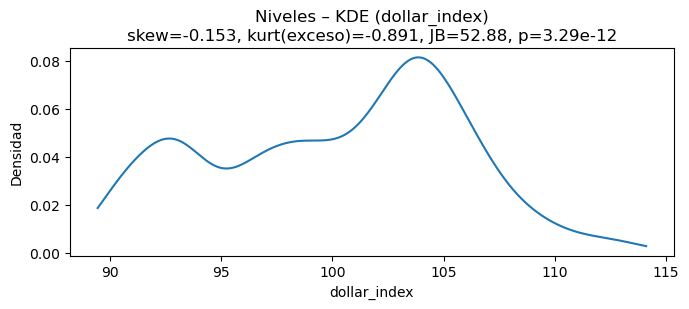

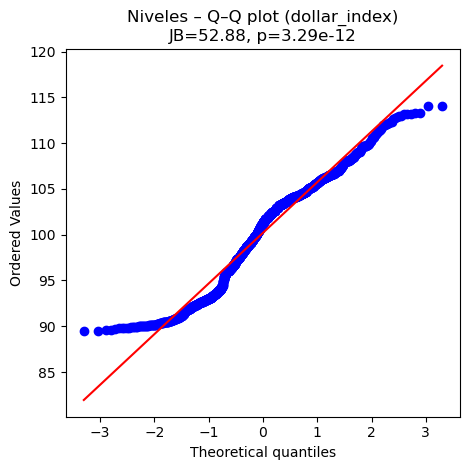

[Niveles / dollar_index] skew=-0.1533, kurt(exceso)=-0.8908, JB=52.8797, p=3.29096e-12, n=1427


In [63]:
plot_kde_qq_levels(s)

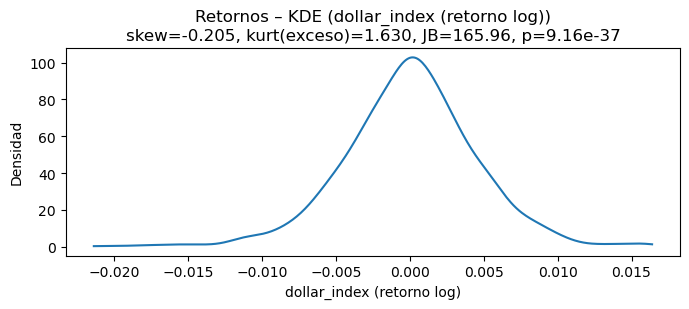

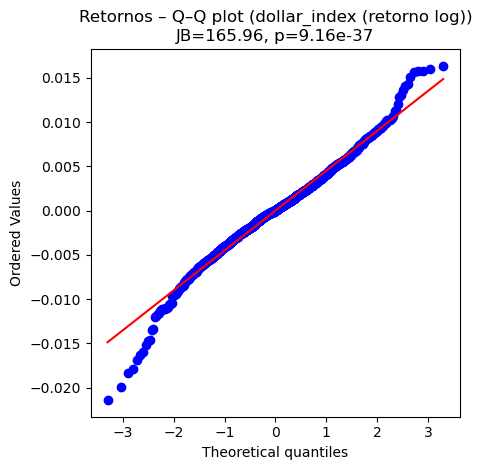

[Retornos / dollar_index (retorno log)] skew=-0.2048, kurt(exceso)=1.6303, JB=165.9609, p=9.16309e-37, n=1426


In [64]:
plot_kde_qq_returns(s, mode="log")  

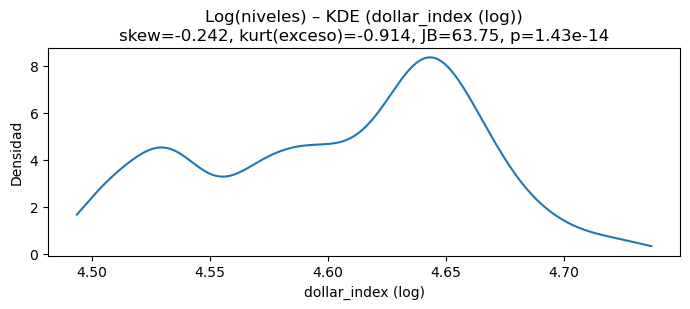

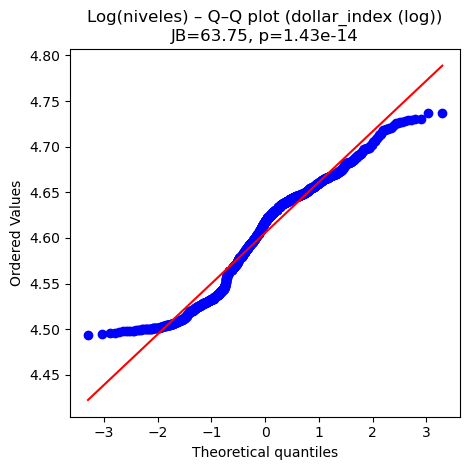

[Log(niveles) / dollar_index (log)] skew=-0.2423, kurt(exceso)=-0.9143, JB=63.7549, p=1.43156e-14, n=1427


In [65]:
plot_kde_qq_log_levels(s)


El Dollar Index presenta una distribución bimodal y ligeramente asimétrica, con mayor densidad entre 95 y 105 puntos, reflejando periodos de fortalecimiento y corrección del dólar frente a otras divisas. Los retornos simples muestran una concentración alrededor de cero y colas finas, consistentes con la baja volatilidad típica de índices cambiarios. 


### **Tendencia**

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ========= utilidades básicas =========
def _clean_series_indexed(s: pd.Series) -> pd.Series:
    """Index datetime, numérico, sin NaN/Inf."""
    s = s.copy()
    if not isinstance(s.index, pd.DatetimeIndex):
        s.index = pd.to_datetime(s.index, errors='coerce')
    s = s.sort_index()
    s = pd.to_numeric(s, errors='coerce').replace([np.inf, -np.inf], np.nan).dropna()
    s.name = s.name or "variable"
    return s

def _rolling_trend(x: pd.Series, window: int = 60, center: bool = True, how: str = "mean") -> pd.Series:
    """
    Tendencia por ventana móvil.
    how: 'mean' (media) o 'median' (mediana robusta).
    """
    window = max(int(window), 3)
    if how == "median":
        trend = x.rolling(window=window, center=center, min_periods=max(3, window//3)).median()
    else:
        trend = x.rolling(window=window, center=center, min_periods=max(3, window//3)).mean()
    return trend

def _plot_trend(x: pd.Series, trend: pd.Series, title: str, ylabel: str):
    plt.figure(figsize=(9,4))
    plt.plot(x.index, x.values, alpha=0.45, label='Serie')
    plt.plot(trend.index, trend.values, linewidth=2.2, label='Tendencia')
    plt.title(title)
    plt.xlabel("Fecha"); plt.ylabel(ylabel)
    plt.legend()
    plt.tight_layout(); plt.show()

# ========= 1) NIVELES =========
def plot_trend_levels(s: pd.Series, window: int = 60, center: bool = True, how: str = "mean"):
    """
    Grafica la serie en niveles y su tendencia rolling.
    window: tamaño de ventana
    center: True → ventana centrada
    how: 'mean' o 'median'
    """
    x = _clean_series_indexed(s)
    trend = _rolling_trend(x, window=window, center=center, how=how)
    _plot_trend(x, trend, title=f"Tendencia – niveles: {x.name}", ylabel=x.name)

# ========= 2) RETORNOS LOG =========
def plot_trend_log_returns(s: pd.Series, window: int = 60, center: bool = True, how: str = "mean"):
    """
    Grafica retornos log (diff(log)) y su tendencia rolling.
    """
    s = _clean_series_indexed(s)
    r = np.log(s).diff().dropna()
    r.name = (s.name or "variable") + " (ret log)"
    trend = _rolling_trend(r, window=window, center=center, how=how)
    _plot_trend(r, trend, title=f"Tendencia – retornos log: {s.name}", ylabel="retorno log")

# ========= 3) LOG(NIVELES) =========
def plot_trend_log_levels(s: pd.Series, window: int = 60, center: bool = True, how: str = "mean"):
    """
    Grafica log(niveles) y su tendencia rolling.
    """
    s = _clean_series_indexed(s).replace(0, np.nan).dropna()
    x = np.log(s)
    x.name = (s.name or "variable") + " (log)"
    trend = _rolling_trend(x, window=window, center=center, how=how)
    _plot_trend(x, trend, title=f"Tendencia – log(niveles): {s.name}", ylabel="log(niveles)")


#### **SP500**

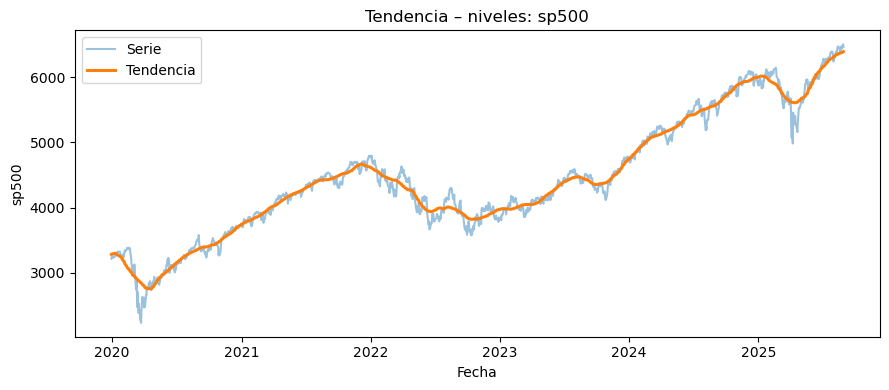

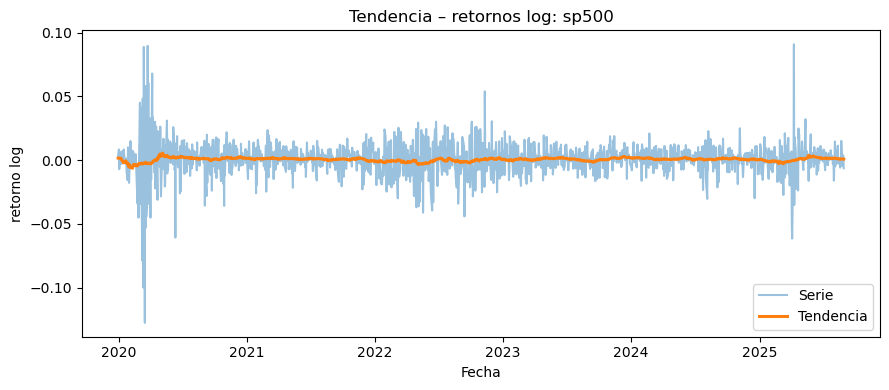

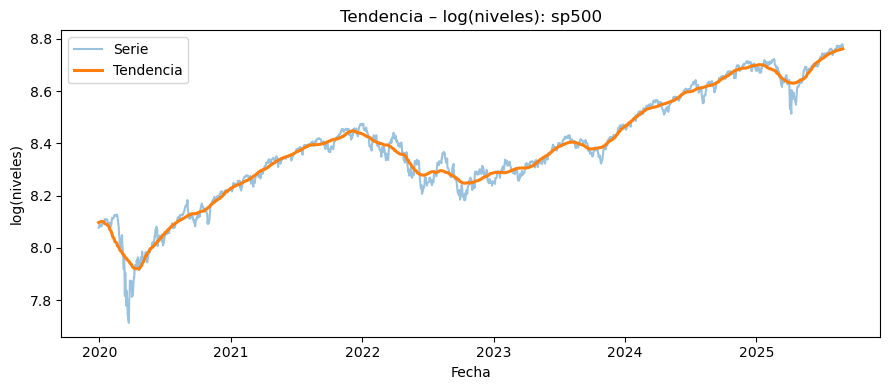

In [33]:
plot_trend_levels(s, window=60)            # niveles
plot_trend_log_returns(s, window=60)       # retornos log
plot_trend_log_levels(s, window=60)        # log(niveles)



El S&P 500 muestra una tendencia alcista con caídas puntuales y recuperación sostenida; en log-niveles la trayectoria se suaviza y los retornos log no presentan tendencia.

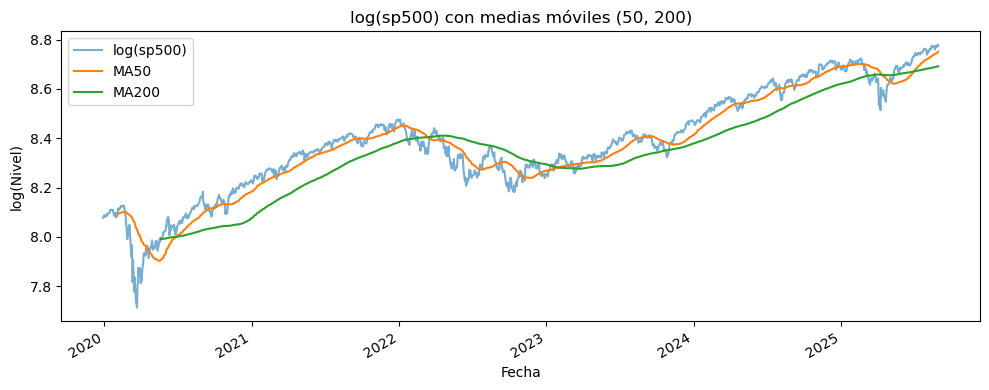

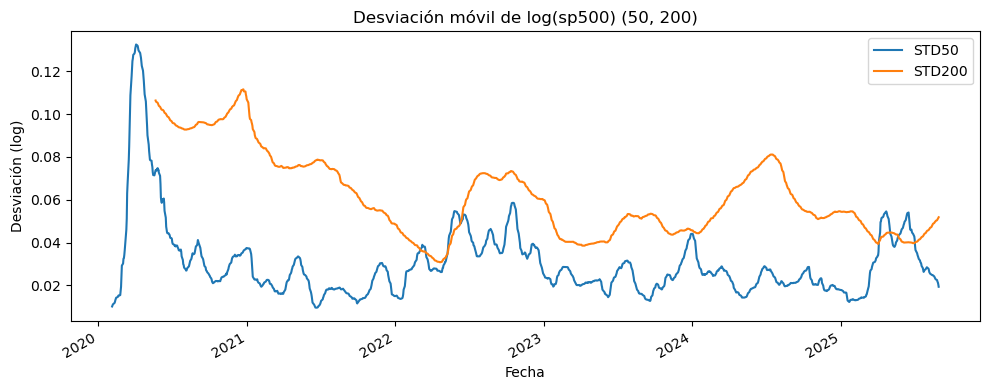

In [47]:
s = df_exog['sp500'].copy()

# Limpieza mínima y aseguramos índice de fechas ordenado

if not isinstance(s.index, pd.DatetimeIndex):
    s.index = pd.to_datetime(s.index, errors='coerce')
s = (pd.to_numeric(s, errors='coerce')
       .replace([np.inf, -np.inf], np.nan)
       .dropna()
       .sort_index())


# La serie debe ser estrictamente positiva para usar log
assert (s > 0).all(), "La serie debe ser positiva para usar log."
log_s = np.log(s)

# --- rollings: medias y desviaciones de log(niveles) ---
rolls = {}
for w in [50, 200]:

    ma  = log_s.rolling(window=w, min_periods=w//2).mean()
    std = log_s.rolling(window=w, min_periods=w//2).std()


    rolls[f"ma{w}"]  = ma
    rolls[f"std{w}"] = std

# --- Gráficas ---
plt.figure(figsize=(10,4))
log_s.plot(alpha=0.6)
rolls["ma50"].plot()
rolls["ma200"].plot()
plt.title('log(sp500) con medias móviles (50, 200)')
plt.legend(['log(sp500)','MA50','MA200'])
plt.ylabel('log(Nivel)'); plt.xlabel('Fecha')
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4))
rolls["std50"].plot()
rolls["std200"].plot()
plt.title('Desviación móvil de log(sp500) (50, 200)')
plt.legend(['STD50','STD200'])
plt.ylabel('Desviación (log)'); plt.xlabel('Fecha')
plt.tight_layout(); plt.show()


Las medias móviles en log confirman el patrón alcista del S&P 500, con cruces MA50 > MA200 en la mayor parte del periodo y sin rupturas bruscas. La desviación móvil muestra alta volatilidad solo al inicio de 2020 y luego una estabilización progresiva, lo que indica que imputar huecos cortos en log-niveles no alterará la estructura de tendencia ni la variabilidad del índice.

#### **WTI_OIL**

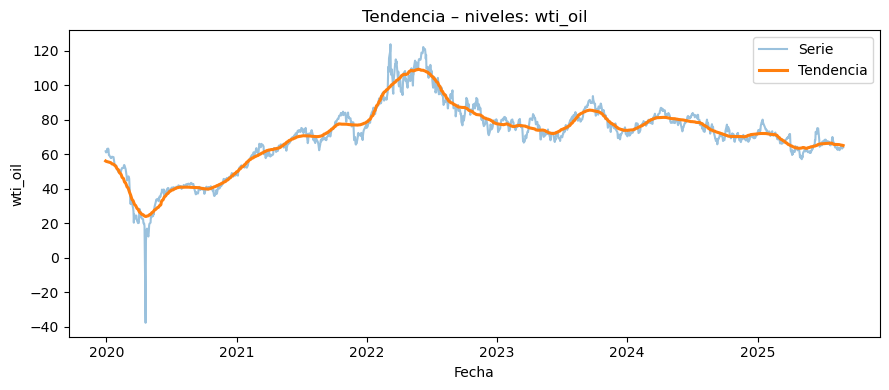

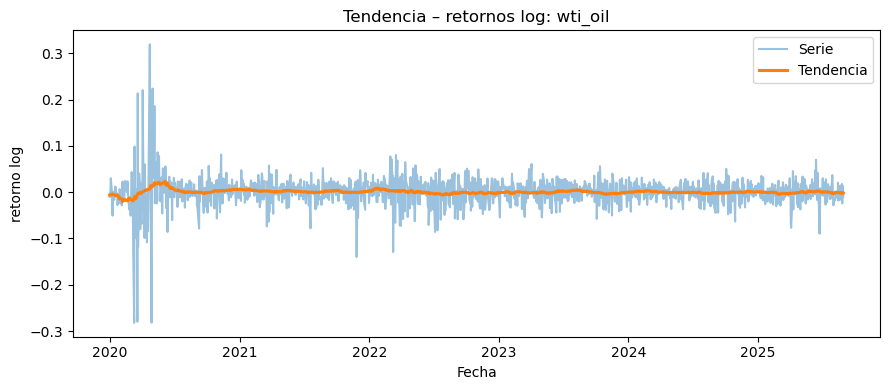

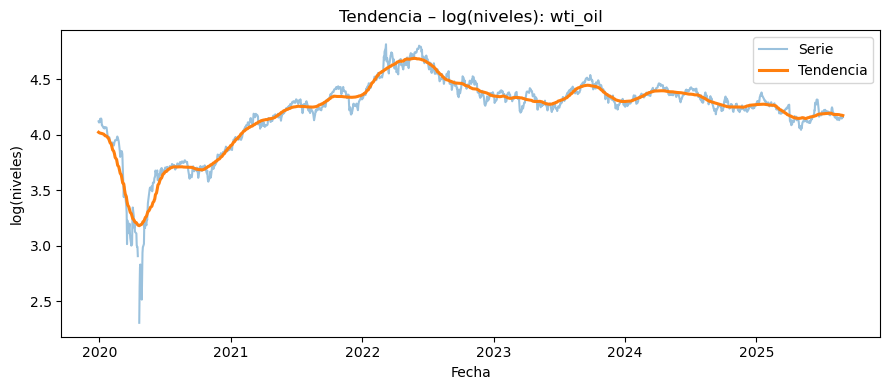

In [45]:
plot_trend_levels(s, window=60)            # niveles
plot_trend_log_returns(s, window=60)       # retornos log
plot_trend_log_levels(s, window=60) 

El WTI muestra una trayectoria con fuerte caída en 2020, recuperación acelerada hasta 2022 y una fase descendente más gradual después. En log-niveles la forma se mantiene pero con menor amplitud, lo que confirma que la transformación suaviza la serie sin alterar su patrón. Los retornos log están centrados en cero y solo presentan alta volatilidad al inicio del periodo, por lo que no se imputarán. Como los huecos observados corresponden únicamente a fines de semana y no exceden 1–2 días, se aplicará interpolación lineal en log-niveles para mantener coherencia con el resto de las series de precios.

#### **VIX**

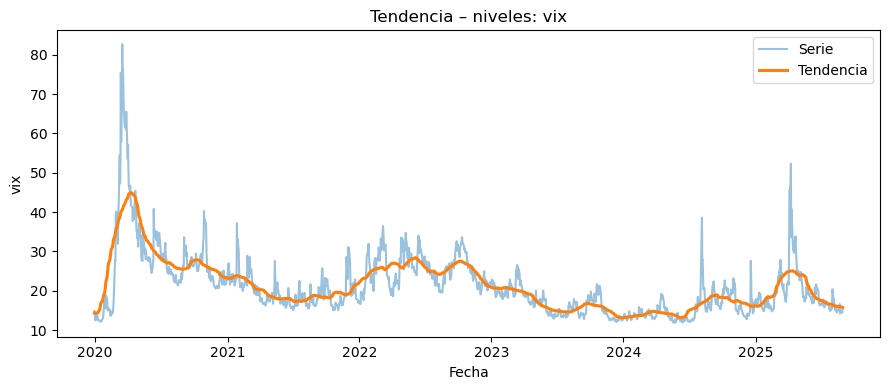

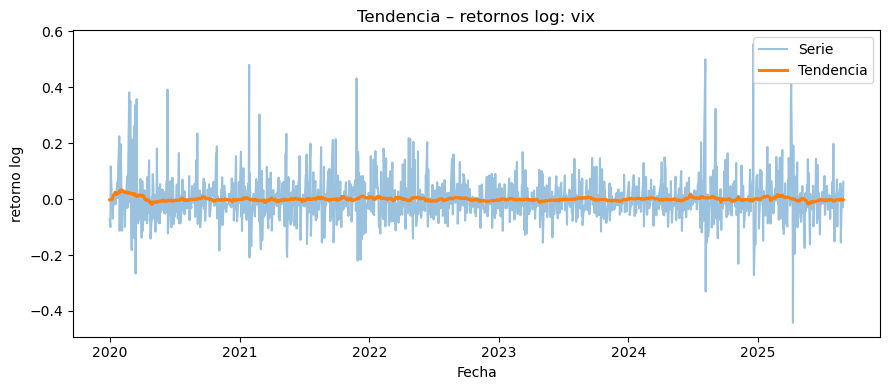

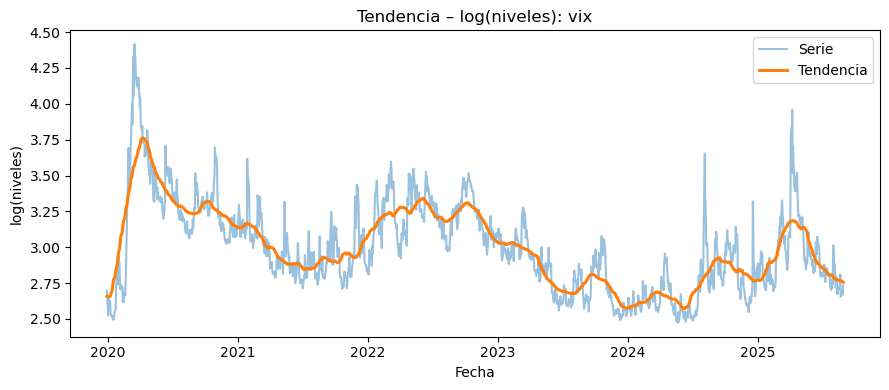

In [56]:
plot_trend_levels(s, window=60)            # niveles
plot_trend_log_returns(s, window=60)       # retornos log
plot_trend_log_levels(s, window=60)        # log(niveles)



El VIX muestra caídas tras el pico de 2020 y variaciones cíclicas posteriores. La serie en log reduce extremos y los retornos log se mantienen centrados en cero.

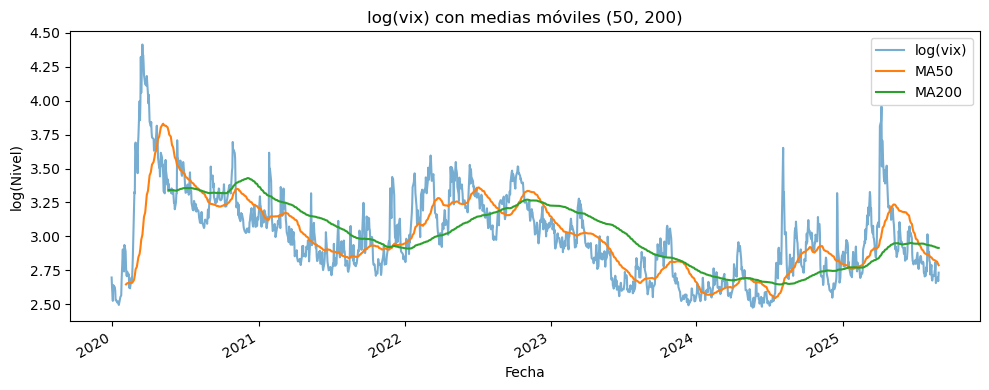

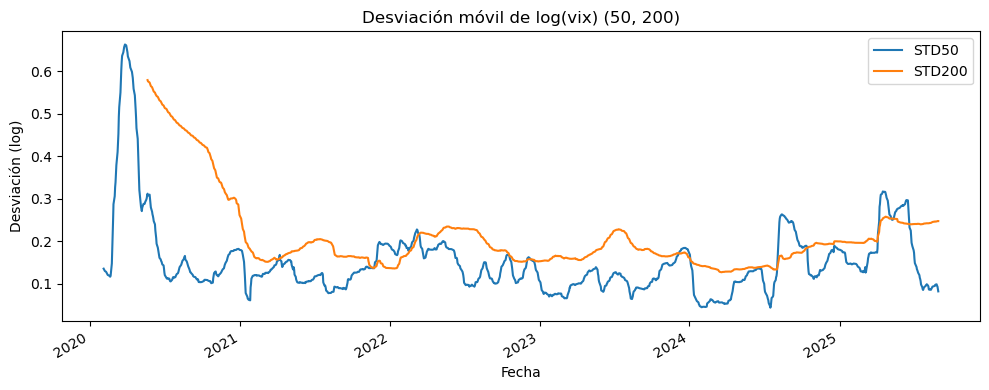

In [68]:
s = df_exog['vix'].copy()

# Limpieza mínima y aseguramos índice de fechas ordenado

if not isinstance(s.index, pd.DatetimeIndex):
    s.index = pd.to_datetime(s.index, errors='coerce')
s = (pd.to_numeric(s, errors='coerce')
       .replace([np.inf, -np.inf], np.nan)
       .dropna()
       .sort_index())


# La serie debe ser estrictamente positiva para usar log
assert (s > 0).all(), "La serie debe ser positiva para usar log."
log_s = np.log(s)

# --- rollings: medias y desviaciones de log(niveles) ---
rolls = {}
for w in [50, 200]:

    ma  = log_s.rolling(window=w, min_periods=w//2).mean()
    std = log_s.rolling(window=w, min_periods=w//2).std()


    rolls[f"ma{w}"]  = ma
    rolls[f"std{w}"] = std

# --- Gráficas ---
plt.figure(figsize=(10,4))
log_s.plot(alpha=0.6)
rolls["ma50"].plot()
rolls["ma200"].plot()
plt.title('log(vix) con medias móviles (50, 200)')
plt.legend(['log(vix)','MA50','MA200'])
plt.ylabel('log(Nivel)'); plt.xlabel('Fecha')
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4))
rolls["std50"].plot()
rolls["std200"].plot()
plt.title('Desviación móvil de log(vix) (50, 200)')
plt.legend(['STD50','STD200'])
plt.ylabel('Desviación (log)'); plt.xlabel('Fecha')
plt.tight_layout(); plt.show()


Las medias móviles y la desviación móvil del log(VIX) muestran que la volatilidad fue muy alta al inicio de 2020 y luego se redujo, con repuntes ocasionales. Como los faltantes solo ocurren en fines de semana, se imputará con interpolación lineal en log-niveles, manteniendo la continuidad de la serie sin afectar su comportamiento.

#### **DOLLAR_INDEX**

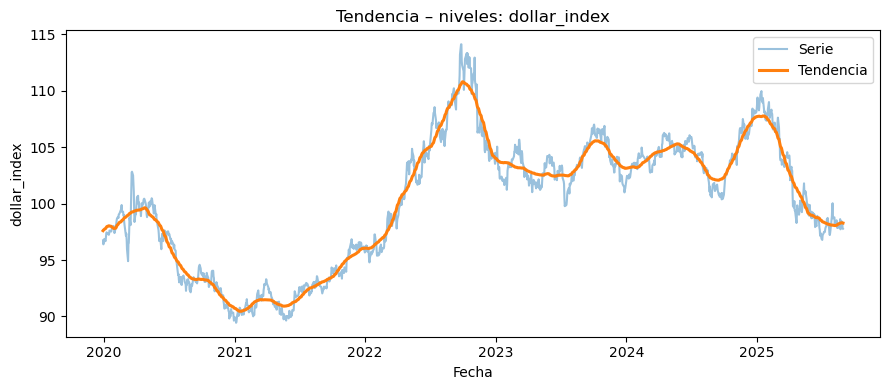

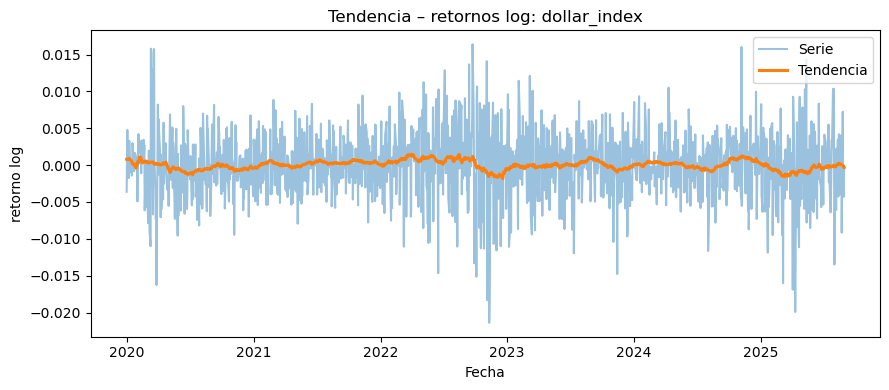

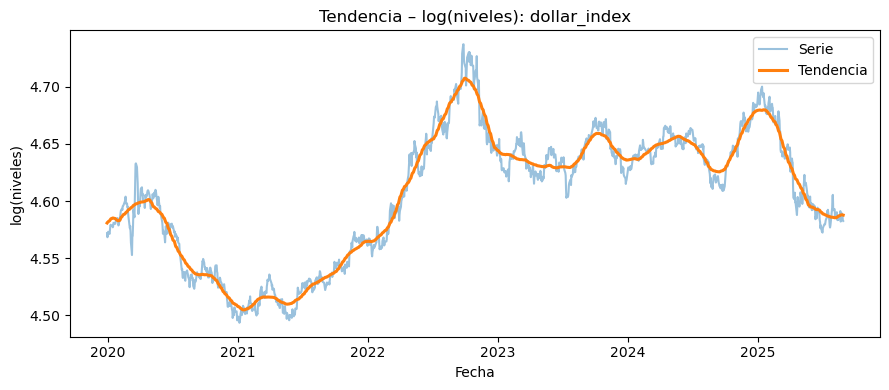

In [66]:
plot_trend_levels(s, window=60)            # niveles
plot_trend_log_returns(s, window=60)       # retornos log
plot_trend_log_levels(s, window=60)        # log(niveles)



El dollar_index muestra una tendencia cíclica clara, con máximos en 2022-2023 y una caída posterior. Los retornos logarítmicos son volátiles pero sin cambios estructurales.

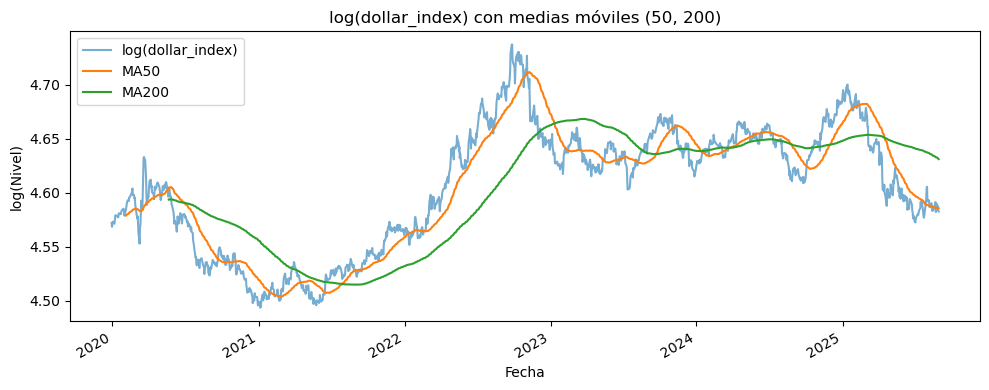

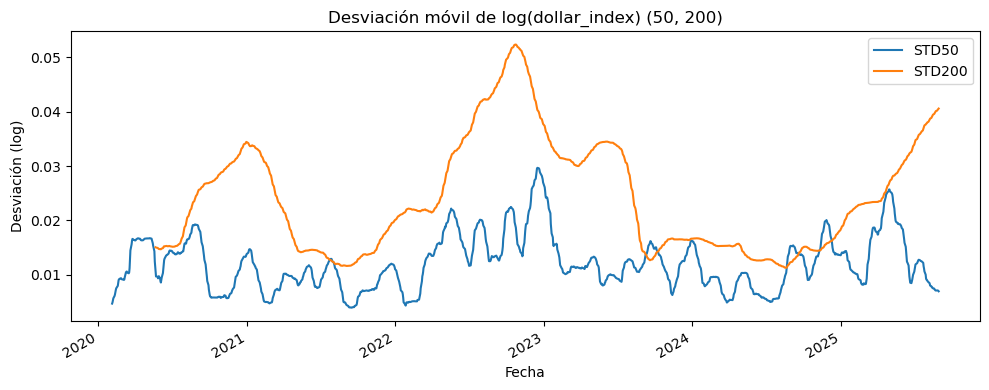

In [67]:
s = df_exog['dollar_index'].copy()

# Limpieza mínima y aseguramos índice de fechas ordenado

if not isinstance(s.index, pd.DatetimeIndex):
    s.index = pd.to_datetime(s.index, errors='coerce')
s = (pd.to_numeric(s, errors='coerce')
       .replace([np.inf, -np.inf], np.nan)
       .dropna()
       .sort_index())


# La serie debe ser estrictamente positiva para usar log
assert (s > 0).all(), "La serie debe ser positiva para usar log."
log_s = np.log(s)

# --- rollings: medias y desviaciones de log(niveles) ---
rolls = {}
for w in [50, 200]:

    ma  = log_s.rolling(window=w, min_periods=w//2).mean()
    std = log_s.rolling(window=w, min_periods=w//2).std()


    rolls[f"ma{w}"]  = ma
    rolls[f"std{w}"] = std

# --- Gráficas ---
plt.figure(figsize=(10,4))
log_s.plot(alpha=0.6)
rolls["ma50"].plot()
rolls["ma200"].plot()
plt.title('log(dollar_index) con medias móviles (50, 200)')
plt.legend(['log(dollar_index)','MA50','MA200'])
plt.ylabel('log(Nivel)'); plt.xlabel('Fecha')
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4))
rolls["std50"].plot()
rolls["std200"].plot()
plt.title('Desviación móvil de log(dollar_index) (50, 200)')
plt.legend(['STD50','STD200'])
plt.ylabel('Desviación (log)'); plt.xlabel('Fecha')
plt.tight_layout(); plt.show()


El log(dollar_index) mantiene una estructura de tendencia suave capturada por las medias móviles de 50 y 200 días, mostrando fases de apreciación entre 2021-2023 y una corrección posterior. La volatilidad en ventanas móviles (STD50 y STD200) revela picos claros alrededor de 2021 y 2023, mientras que el periodo 2024-2025 presenta menor variabilidad relativa.

### **METODO DE IMPUTACION**

Se imputarán los datos de sp500, wti_oil, vix y dollar_index mediante interpolación log-lineal,